# Fine-tuning for Video Classification with 🤗 Transformers

This notebook shows how to fine-tune a pre-trained Vision model for Video Classification on a custom dataset. The idea is to add a randomly initialized classification head on top of a pre-trained encoder and fine-tune the model altogether on a labeled dataset.


## Dataset

This notebook uses the pre-processed SSBD/ESBD dataset. The datasets were prepared using the pretrained YOLOv5 objection detection model and a few more steps that are defined the the ReadMe.txt file and the project report.

## Model

We'll fine-tune the [VideoMAE model](https://huggingface.co/docs/transformers/model_doc/videomae), which was pre-trained on the [Kinetics 400 dataset](https://www.deepmind.com/open-source/kinetics). More variants of the VideoMAE available on 🤗 Hub [here](https://huggingface.co/models?search=videomae) that we plan on using later. We also intend to use other video models such as [X-CLIP](https://huggingface.co/docs/transformers/model_doc/xclip#transformers.XCLIPVisionModel).

**Note** that for models where there's no classification head already available we'll have to manually attach it (randomly initialized). But this is not the case for VideoMAE since we already have a [`VideoMAEForVideoClassification`](https://huggingface.co/docs/transformers/model_doc/xclip#transformers.XCLIPVisionModel) class.
---

Depending on the model and the GPU available we adjust the batch size to avoid out-of-memory errors.

In [114]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [115]:
file_dir = '/content/drive/MyDrive/ESBD.tar.gz'

In [116]:
model_ckpt = "MCG-NJU/videomae-base" # pre-trained model from which to fine-tune
batch_size = 1 # batch size for training and evaluation

Before we start, let's install the `pytorchvideo`, `transformers`, and `evaluate` libraries.

In [4]:
!pip install pytorchvideo transformers evaluate -q

If you're opening this notebook locally, make sure your environment has an install from the lastest version of these libraries.

## Fine-tuning a model on a video classification task

In this notebook, we are fine-tuning VideoMAE which is one of the [🤗 Transformers](https://github.com/huggingface/transformers) vision models on the SSBD/ESBD ASD Video Classification dataset.

Given a video, the goal is to predict an appropriate class for it, like "spinning".

### Loading the dataset

Here we first download the subset archive and un-archive it.

In [117]:
!tar xf {file_dir}

Now, let's investigate what is inside the archive.

In [119]:
dataset_root_path = "/content/home/aleenahkahn/ASD/data/ESBD/"

!find {dataset_root_path} | head -5

/content/home/aleenahkahn/ASD/data/ESBD/
/content/home/aleenahkahn/ASD/data/ESBD/test
/content/home/aleenahkahn/ASD/data/ESBD/test/ArmFlapping
/content/home/aleenahkahn/ASD/data/ESBD/test/ArmFlapping/armflapping_29_9.avi
/content/home/aleenahkahn/ASD/data/ESBD/test/ArmFlapping/armflapping_27_63.avi


Let's now count the number of total videos we have.

In [120]:
import pathlib

dataset_root_path = pathlib.Path(dataset_root_path)

In [121]:
video_count_train = len(list(dataset_root_path.glob("train/*/*.avi")))
video_count_val = len(list(dataset_root_path.glob("val/*/*.avi")))
video_count_test = len(list(dataset_root_path.glob("test/*/*.avi")))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 2032


In [122]:
all_video_file_paths = (
    list(dataset_root_path.glob("train/*/*.avi"))
    + list(dataset_root_path.glob("val/*/*.avi"))
    + list(dataset_root_path.glob("test/*/*.avi"))
)
all_video_file_paths[:5]

[PosixPath('/content/home/aleenahkahn/ASD/data/ESBD/train/ArmFlapping/armflapping_15_19.avi'),
 PosixPath('/content/home/aleenahkahn/ASD/data/ESBD/train/ArmFlapping/armflapping_12_39.avi'),
 PosixPath('/content/home/aleenahkahn/ASD/data/ESBD/train/ArmFlapping/armflapping_15_14.avi'),
 PosixPath('/content/home/aleenahkahn/ASD/data/ESBD/train/ArmFlapping/armflapping_07_32.avi'),
 PosixPath('/content/home/aleenahkahn/ASD/data/ESBD/train/ArmFlapping/armflapping_18_45.avi')]

Next up, we derive the set of labels we have in the dataset. Let's also create two dictionaries that'll be helpful when initializing the model:

* `label2id`: maps the class names to integers.
* `id2label`: maps the integers to class names.

In [123]:
class_labels = sorted({str(path).split("/")[8] for path in all_video_file_paths})
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"Unique classes: {list(label2id.keys())}.")

Unique classes: ['ArmFlapping', 'HandAction', 'HeadBanging', 'Spinning'].


### Loading the model

In the next cell, we initialize a video classification model where the encoder is initialized with the pre-trained parameters and the classification head is randomly initialized. We also initialize the feature extractor associated to the model. This will come in handy during writing the preprocessing pipeline for our dataset.

In [124]:
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification


image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
model = VideoMAEForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The warning is telling us we are throwing away some weights (e.g. the weights and bias of the `classifier` layer) and randomly initializing some other (the weights and bias of a new `classifier` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

**Note** that [this checkpoint](https://huggingface.co/MCG-NJU/videomae-base-finetuned-kinetics) leads to better performance on this task as the checkpoint was obtained fine-tuning on a similar downstream task having considerable domain overlap. You can check out [this checkpoint](https://huggingface.co/sayakpaul/videomae-base-finetuned-kinetics-finetuned-ucf101-subset) which was obtained by fine-tuning `MCG-NJU/videomae-base-finetuned-kinetics` and it obtains much better performance.  

### Constructing the datasets for training

For preprocessing the videos, we'll leverage the [PyTorch Video library](https://pytorchvideo.org/). We start by importing the dependencies we need.

In [125]:
import pytorchvideo.data

from pytorchvideo.transforms import (
    ApplyTransformToKey,
    Normalize,
    RandomShortSideScale,
    RemoveKey,
    ShortSideScale,
    UniformTemporalSubsample,
)

from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)

For the training dataset transformations, we use a combination of uniform temporal subsampling, pixel normalization, random cropping, and random horizontal flipping. For the validation and evaluation dataset transformations, we keep the transformation chain the same except for random cropping and horizontal flipping. To learn more about the details of these transformations check out the [official documentation of PyTorch Video](https://pytorchvideo.org).  

We'll use the `image_processor` associated with the pre-trained model to obtain the following information:

* Image mean and standard deviation with which the video frame pixels will be normalized.
* Spatial resolution to which the video frames will be resized.

In [126]:
import os

mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)

num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps


# Training dataset transformations.
train_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    RandomShortSideScale(min_size=256, max_size=320),
                    RandomCrop(resize_to),
                    RandomHorizontalFlip(p=0.5),
                ]
            ),
        ),
    ]
)

# Training dataset.
train_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "train"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("random", clip_duration),
    decode_audio=False,
    transform=train_transform,
)

# Validation and evaluation datasets' transformations.
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

# Validation and evaluation datasets.
val_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "val"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join(dataset_root_path, "test"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

**Note**: The above dataset pipelines are taken from the [official PyTorch Video example](https://pytorchvideo.org/docs/tutorial_classification#dataset). We're using the [`pytorchvideo.data.Ucf101()`](https://pytorchvideo.readthedocs.io/en/latest/api/data/data.html#pytorchvideo.data.Ucf101) function because it's tailored for the UCF-101 dataset. Under the hood, it returns a [`pytorchvideo.data.labeled_video_dataset.LabeledVideoDataset`](https://pytorchvideo.readthedocs.io/en/latest/api/data/data.html#pytorchvideo.data.LabeledVideoDataset) object. `LabeledVideoDataset` class is the base class for all things video in the PyTorch Video dataset. So, if you wanted to use a custom dataset not supported off-the-shelf by PyTorch Video, you can extend the `LabeledVideoDataset` class accordingly. Refer to the `data` API [documentation to](https://pytorchvideo.readthedocs.io/en/latest/api/data/data.html) learn more. Also, if your dataset follows a similar structure (as shown above), then using the `pytorchvideo.data.Ucf101()` should work just fine.

In [127]:
# We can access the `num_videos` argument to know the number of videos we have in the
# dataset.
train_dataset.num_videos, val_dataset.num_videos, test_dataset.num_videos

(1523, 305, 204)

Let's now take a preprocessed video from the dataset and investigate it.

In [128]:
sample_video = next(iter(train_dataset))
sample_video.keys()

dict_keys(['video', 'video_name', 'video_index', 'clip_index', 'aug_index', 'label'])

In [129]:
def investigate_video(sample_video):
    """Utility to investigate the keys present in a single video sample."""
    for k in sample_video:
        if k == "video":
            print(k, sample_video["video"].shape)
        else:
            print(k, sample_video[k])

    print(f"Video label: {id2label[sample_video[k]]}")


investigate_video(sample_video)

video torch.Size([3, 16, 224, 224])
video_name handaction_06_79.avi
video_index 800
clip_index 0
aug_index 0
label 1
Video label: HandAction


We can also visualize the preprocessed videos for easier debugging.

In [130]:
import imageio
import numpy as np
from IPython.display import Image


def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)


def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.

    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename


def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)

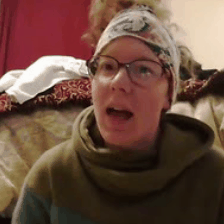

In [131]:
video_tensor = sample_video["video"]
display_gif(video_tensor)

### Training the model

We'll leverage [`Trainer`](https://huggingface.co/docs/transformers/main_classes/trainer) from  🤗 Transformers for training the model. To instantiate a `Trainer`, we will need to define the training configuration and an evaluation metric. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to configure the training. It requires an output folder name, which will be used to save the checkpoints of the model. It also helps sync all the information in the model repository on 🤗 Hub.

Most of the training arguments are pretty self-explanatory, but one that is quite important here is `remove_unused_columns=False`. This one will drop any features not used by the model's call function. By default it's `True` because usually it's ideal to drop unused feature columns, making it easier to unpack inputs into the model's call function. But, in our case, we need the unused features ('video' in particular) in order to create `pixel_values` (which is a mandatory key our model expects in its inputs).

In [22]:
!pip uninstall accelerate -y

In [23]:
!python -m pip install accelerate==0.27.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 5.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [132]:
from transformers import TrainingArguments, Trainer

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-ASD"
num_epochs = 5

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    max_steps=(train_dataset.num_videos // batch_size) * num_epochs,
)

There's no need to define `max_steps` when instantiating `TrainingArguments`. Since the dataset returned by `pytorchvideo.data.Ucf101()` doesn't implement the `__len__()` method we had to specify `max_steps`.  

Next, we need to define a function for how to compute the metrics from the predictions, which will just use the `metric` we'll load now. The only preprocessing we have to do is to take the argmax of our predicted logits:

In [133]:
import evaluate

metric = evaluate.load("accuracy")

In [134]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions."""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

**A note on evaluation**:

In the [VideoMAE paper](https://arxiv.org/abs/2203.12602), the authors use the following evaluation strategy. They evaluate the model on several clips from test videos and apply different crops to those clips and report the aggregate score. However, in the interest of simplicity and brevity, we don't consider that in this tutorial.

We also define a `collate_fn`, which will be used to batch examples together.
Each batch consists of 2 keys, namely `pixel_values` and `labels`.

In [135]:
import torch


def collate_fn(examples):
    """The collation function to be used by `Trainer` to prepare data batches."""
    # permute to (num_frames, num_channels, height, width)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [136]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

max_steps is given, it will override any value given in num_train_epochs


You might wonder why we pass along the `image_processor` as a tokenizer when we already preprocessed our data. This is only to make sure the feature extractor configuration file (stored as JSON) will also be uploaded to the repo on the hub.

Now we can finetune our model by calling the `train` method:

In [137]:
train_results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
0,1.523600,1.410669,0.252459
1,1.344500,1.778955,0.377049
2,1.339600,1.455402,0.377049
3,1.769500,1.583273,0.377049
4,1.129400,1.835446,0.278689


We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [138]:
trainer.evaluate(test_dataset)

{'eval_loss': 1.784536600112915,
 'eval_accuracy': 0.37745098039215685,
 'eval_runtime': 74.2802,
 'eval_samples_per_second': 10.985,
 'eval_steps_per_second': 10.985,
 'epoch': 4.2}

In [139]:
trainer.save_model()
test_results = trainer.evaluate(test_dataset)
trainer.log_metrics("test", test_results)
trainer.save_metrics("test", test_results)
trainer.save_state()

***** test metrics *****
  epoch                   =        4.2
  eval_accuracy           =     0.3775
  eval_loss               =     1.7845
  eval_runtime            = 0:01:13.05
  eval_samples_per_second =      11.17
  eval_steps_per_second   =      11.17


You can now upload the result of the training to the Hub, just execute this instruction (note that the Trainer will automatically create a model card as well as Tensorboard logs - see the "Training metrics" tab - amazing isn't it?):

Now that our model is trained, let's use it to run inference on a video from `test_dataset`.

## Inference

Let's load the trained model checkpoint and fetch a video from `test_dataset`.

In [140]:
trained_model = VideoMAEForVideoClassification.from_pretrained(new_model_name)

In [141]:
sample_test_video = next(iter(test_dataset))
investigate_video(sample_test_video)

video torch.Size([3, 16, 224, 224])
video_name armflapping_29_6.avi
video_index 73
clip_index 0
aug_index 0
label 0
Video label: ArmFlapping


We then prepare the video as a `torch.Tensor` and run inference.

In [142]:
def run_inference(model, video):
    """Utility to run inference given a model and test video.

    The video is assumed to be preprocessed already.
    """
    # (num_frames, num_channels, height, width)
    perumuted_sample_test_video = video.permute(1, 0, 2, 3)

    inputs = {
        "pixel_values": perumuted_sample_test_video.unsqueeze(0),
        "labels": torch.tensor(
            [sample_test_video["label"]]
        ),  # this can be skipped if you don't have labels available.
    }
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    return logits

In [143]:
logits = run_inference(trained_model, sample_test_video["video"])

We can now check if the model got the prediction right.

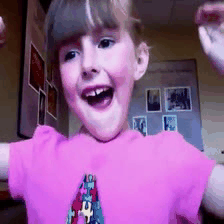

In [144]:
display_gif(sample_test_video["video"])

In [145]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: ArmFlapping


## Next steps

Now that you've learned to train a well-performing video classification model on a custom dataset here is some homework for you:

* Increase the dataset size: include more classes and more samples per class.
* Try out different hyperparameters to study how the model converges.
* Analyze the classes for which the model fails to perform well.
* Try out a different video encoder.

Don't forget to share your models with the community =)